In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# raw_data_path = os.path.join('..', 'data', 'raw', 'ring_details.xlsx')
# df0 = pd.read_excel(raw_data_path)

In [3]:
# connect to DB
conn = sqlite3.connect('../data/jewelry.db')

query = """
SELECT p.*, ph.price 
FROM products p 
JOIN price_history ph ON p.Reference = ph.refcode
"""

df0 = pd.read_sql(query, conn)

# Validate numbers of columns and rows
print(f"Columns in df0: {df0.columns.tolist()}")
print(f"Total rows: {len(df0)}")

Columns in df0: ['Image', 'Reference', 'Price', 'Series:', 'Model:', 'Model Variant:', 'Category:', 'Style Type:', 'Alloy:', 'Range:', 'Shank Profile:', 'Shank Style:', 'Setting Claw Type:', 'Setting Style:', 'Guide Weight:', 'Stone Type:', 'Stone Quantity:', 'Stone Shape:', 'Stone Size (mm):', 'Stone Size (ct):', 'Stone Description:', 'Diamond Round / Brilliant Cut - Various mm:', '£ Per g', 'price']
Total rows: 2303


In [4]:
df0.head()

,Image,Reference,Price,Series:,Model:,Model Variant:,Category:,Style Type:,Alloy:,Range:,...,Guide Weight:,Stone Type:,Stone Quantity:,Stone Shape:,Stone Size (mm):,Stone Size (ct):,Stone Description:,Diamond Round / Brilliant Cut - Various mm:,£ Per g,price
0,None,9WSDS19-25,136.50,SEMI-RNG-SDS19,RNG-9SDS19-25,RNG-SDS19-25-9W,Rings,NaN,9ct White Gold,Semi Set Mounts,...,1.00g,Diamond,Single Stone,Round / Brilliant Cut,4.00 mm,0.25 ct.,"x30 Dia, 0.14 ct.",NaN,136.500000,136.50
1,None,9WSDS20-25,158.00,SEMI-RNG-SDS20,RNG-9SDS20-25,RNG-SDS20-25-9W,Rings,NaN,9ct White Gold,Semi Set Mounts,...,1.00g,Diamond,Single Stone,Round / Brilliant Cut,4.00 mm,0.25 ct.,"x26 Dia, 0.20 ct.",NaN,158.000000,158.00
2,None,WC0010SSV,925.16,SEMI-RNG-C0010SSV,RNG-C0010SSV,RNG-WC0010SSV,Rings,Snuggle Fit,18ct White Gold,Semi Set Mounts,...,4.06g,Diamond,Single Stone,Oval Cut,6 x 4 mm,0.50 ct.,x55st. 0.68ct. Dia.,0.677ct. x 55,227.871921,925.16
3,None,18WT2752SS,553.80,SEMI-RNG-T2752SS,RNG-T2752SS,RNG-T2752SS-18W,Rings,NaN,18ct White Gold,Semi Set Mounts,...,3.80g,Diamond,Single Stone,Emerald Cut,5 x 4 mm,0.40 ct.,x10st. 0.20ct. Dia.,NaN,145.736842,553.80
4,None,18WT3001SS,452.57,SEMI-RNG-T3001SS,RNG-T3001SS,RNG-T3001SS-18W,Rings,NaN,18ct White Gold,Semi Set Mounts,...,3.25g,Diamond,Three Stones,Princess / Square Cut,3.50 mm,0.23 ct.,x2st. 0.14ct. Dia.,NaN,139.252308,452.57


In [5]:
df0 = df0.drop(columns = ['Image', 'Reference', 'Series:', 'Model:','Model Variant:','Category:', 'Style Type:','Range:','Stone Type:','Stone Description:','Diamond Round / Brilliant Cut - Various mm:','£ Per g'])
df0.columns

Index(['Price', 'Alloy:', 'Shank Profile:', 'Shank Style:',
       'Setting Claw Type:', 'Setting Style:', 'Guide Weight:',
       'Stone Quantity:', 'Stone Shape:', 'Stone Size (mm):',
       'Stone Size (ct):', 'price'],
      dtype='str')

In [6]:
df0.info()

<class 'pandas.DataFrame'>
RangeIndex: 2303 entries, 0 to 2302
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               2263 non-null   float64
 1   Alloy:              2303 non-null   str    
 2   Shank Profile:      2303 non-null   str    
 3   Shank Style:        2303 non-null   str    
 4   Setting Claw Type:  2303 non-null   str    
 5   Setting Style:      2288 non-null   str    
 6   Guide Weight:       2303 non-null   str    
 7   Stone Quantity:     2295 non-null   str    
 8   Stone Shape:        2303 non-null   str    
 9   Stone Size (mm):    2303 non-null   str    
 10  Stone Size (ct):    2303 non-null   str    
 11  price               2263 non-null   float64
dtypes: float64(2), str(10)
memory usage: 216.0 KB


In [7]:
df0.isna().sum()

Price                 40
Alloy:                 0
Shank Profile:         0
Shank Style:           0
Setting Claw Type:     0
Setting Style:        15
Guide Weight:          0
Stone Quantity:        8
Stone Shape:           0
Stone Size (mm):       0
Stone Size (ct):       0
price                 40
dtype: int64

In [8]:
df0[df0['Setting Style:'].isna()]

,Price,Alloy:,Shank Profile:,Shank Style:,Setting Claw Type:,Setting Style:,Guide Weight:,Stone Quantity:,Stone Shape:,Stone Size (mm):,Stone Size (ct):,price
13,781.04,18ct White Gold,Flat Parallel,Squared Shoulder,Rubover,NaN,5.50g,Single Stone,Round / Brilliant Cut,5.00 mm,0.50 ct.,781.04
26,781.04,18ct White Gold,Flat Parallel,Squared Shoulder,Rubover,NaN,5.50g,Single Stone,Round / Brilliant Cut,5.00 mm,0.50 ct.,781.04
540,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,4.00 mm,0.30 ct.,317.69
541,281.71,Platinum,Tapered,Split Shoulder,Four Claw,NaN,4.40g,Three Stones,Princess / Square Cut,4.00 mm,0.30 ct.,281.71
542,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,4.00 mm,0.30 ct.,317.69
543,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,5.00 mm,0.63 ct.,317.69
544,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,5.00 mm,0.63 ct.,317.69
545,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,5.00 mm,0.63 ct.,317.69
546,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,5.50 mm,1.00 ct.,317.69
547,317.69,Platinum,Tapered,Split Shoulder,Four Claw,NaN,5.10g,Three Stones,Princess / Square Cut,5.50 mm,1.00 ct.,317.69


In [9]:
df0 = df0.dropna(subset=['Setting Style:', 'Price']).reset_index(drop=True)
df0.isna().sum()

Price                 0
Alloy:                0
Shank Profile:        0
Shank Style:          0
Setting Claw Type:    0
Setting Style:        0
Guide Weight:         0
Stone Quantity:       8
Stone Shape:          0
Stone Size (mm):      0
Stone Size (ct):      0
price                 0
dtype: int64

In [10]:
# Data Extraction
df0['Guide Weight:'] = df0['Guide Weight:'].str.extract(r'(\d+\.?\d*)').astype(float)
df0['Stone Size (ct):'] = df0['Stone Size (ct):'].str.extract(r'(\d+\.?\d*)').astype(float)
df0['Stone Size (mm):'] = df0['Stone Size (mm):'].replace({' mm': '', 'mm':''}, regex=True)

In [11]:
df0.info()

<class 'pandas.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               2248 non-null   float64
 1   Alloy:              2248 non-null   str    
 2   Shank Profile:      2248 non-null   str    
 3   Shank Style:        2248 non-null   str    
 4   Setting Claw Type:  2248 non-null   str    
 5   Setting Style:      2248 non-null   str    
 6   Guide Weight:       2248 non-null   float64
 7   Stone Quantity:     2240 non-null   str    
 8   Stone Shape:        2248 non-null   str    
 9   Stone Size (mm):    2248 non-null   str    
 10  Stone Size (ct):    2248 non-null   float64
 11  price               2248 non-null   float64
dtypes: float64(4), str(8)
memory usage: 210.9 KB


In [12]:
df = df0.copy()

In [13]:
df.head()

,Price,Alloy:,Shank Profile:,Shank Style:,Setting Claw Type:,Setting Style:,Guide Weight:,Stone Quantity:,Stone Shape:,Stone Size (mm):,Stone Size (ct):,price
0,136.50,9ct White Gold,Tap-up,Split Shoulder,Rubover,Open Gallery,1.00,Single Stone,Round / Brilliant Cut,4.00,0.25,136.50
1,158.00,9ct White Gold,Tap-up,Split Shoulder,Four Claw,Open Gallery,1.00,Single Stone,Round / Brilliant Cut,4.00,0.25,158.00
2,925.16,18ct White Gold,Flat Parallel,Split Shoulder,Four Claw,Base Bezel,4.06,Single Stone,Oval Cut,6 x 4,0.50,925.16
3,553.80,18ct White Gold,Flat Parallel,Squared Shoulder,Four Claw,Double / Treble Gallery,3.80,Single Stone,Emerald Cut,5 x 4,0.40,553.80
4,452.57,18ct White Gold,Flat Parallel,Squared Shoulder,Four Claw,Base Bezel,3.25,Three Stones,Princess / Square Cut,3.50,0.23,452.57


In [14]:
def reorganize_stone_size(row):
    stone_shape = row['Stone Shape:']
    stone_size = row['Stone Size (mm):']
    
    if stone_shape in ['Cushion Cut', 'Princess / Square Cut', 'Asscher Cut']:
        # Single number, interpreted as width (or length)
        return {'Width': float(stone_size), 'Length': float(stone_size)}
    elif stone_shape == 'Round / Brilliant Cut':
        # Single number, interpreted as diameter
        return {'Diameter': float(stone_size)}
    else:
        # For other shapes, split 'length x width' into two numbers
        if 'x' in stone_size:
            length, width = map(float, stone_size.split('x'))
            return {'Length': length, 'Width': width}
        else:
            # Handle cases where the format is unexpected
            return {'Length': None, 'Width': None}

# Apply the function to reorganize the 'Stone Size' column
stone_size_data = df.apply(reorganize_stone_size, axis=1)

# Convert the resulting dictionary into separate columns
stone_size_df = pd.DataFrame(stone_size_data.tolist())

# Merge the new columns back into the original DataFrame
df = pd.concat([df, stone_size_df], axis=1)

df.drop(columns=['Stone Size (mm):'], inplace=True)

# Display the updated DataFrame
df.head()

,Price,Alloy:,Shank Profile:,Shank Style:,Setting Claw Type:,Setting Style:,Guide Weight:,Stone Quantity:,Stone Shape:,Stone Size (ct):,price,Diameter,Length,Width
0,136.50,9ct White Gold,Tap-up,Split Shoulder,Rubover,Open Gallery,1.00,Single Stone,Round / Brilliant Cut,0.25,136.50,4.0,NaN,NaN
1,158.00,9ct White Gold,Tap-up,Split Shoulder,Four Claw,Open Gallery,1.00,Single Stone,Round / Brilliant Cut,0.25,158.00,4.0,NaN,NaN
2,925.16,18ct White Gold,Flat Parallel,Split Shoulder,Four Claw,Base Bezel,4.06,Single Stone,Oval Cut,0.50,925.16,NaN,6.0,4.0
3,553.80,18ct White Gold,Flat Parallel,Squared Shoulder,Four Claw,Double / Treble Gallery,3.80,Single Stone,Emerald Cut,0.40,553.80,NaN,5.0,4.0
4,452.57,18ct White Gold,Flat Parallel,Squared Shoulder,Four Claw,Base Bezel,3.25,Three Stones,Princess / Square Cut,0.23,452.57,NaN,3.5,3.5


In [15]:
processed_path = os.path.join('..', 'data', 'processed', 'cleaned_ring_data.csv')
df.to_csv(processed_path, index=False)
print(f"Cleaned data saved to: {processed_path}")

Cleaned data saved to: ../data/processed/cleaned_ring_data.csv


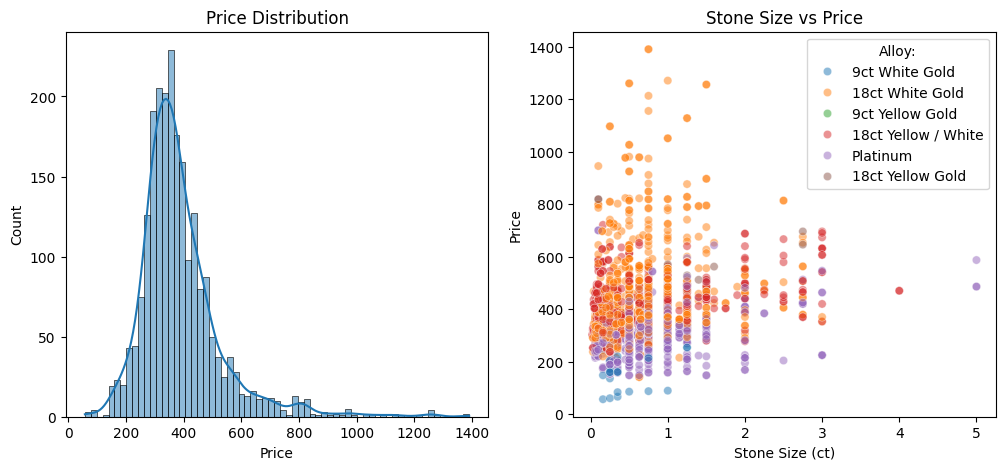

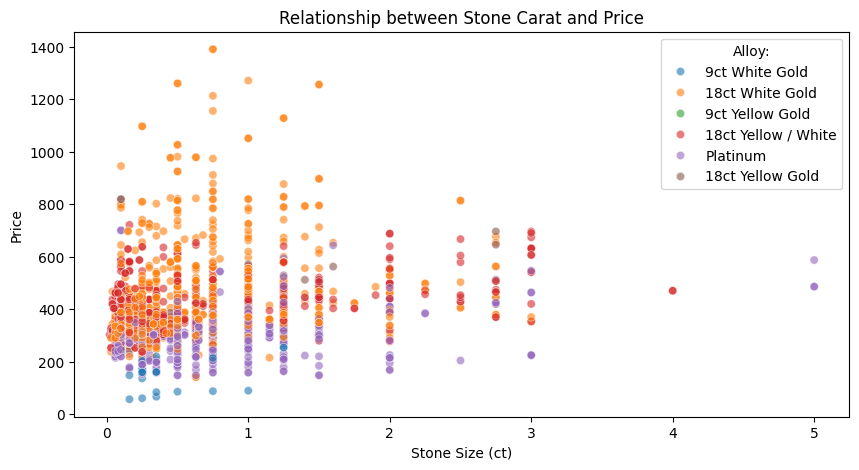

Data cleaning completed and EDA visualization generated.


In [16]:
# Data Cleaning & EDA 

# 1. Fill missing values
df['Stone Size (ct)'] = df['Stone Size (ct):'].fillna(0)


# 2. Explanatory Data Analysis EDA (展示專業性)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True)
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Stone Size (ct)', y='Price', hue='Alloy:', alpha=0.5)
plt.title('Stone Size vs Price')

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Stone Size (ct)', y='Price', hue='Alloy:', alpha=0.6)
plt.title('Relationship between Stone Carat and Price')
plt.show()

print("Data cleaning completed and EDA visualization generated.")

In [17]:
df[['Diameter', 'Length', 'Width']] = df[['Diameter', 'Length', 'Width']].fillna(0)

In [18]:
missing_data = df[(df['Diameter'].isna()) & (df['Length'].isna()) & (df['Width'].isna())]
missing_data

,Price,Alloy:,Shank Profile:,Shank Style:,Setting Claw Type:,Setting Style:,Guide Weight:,Stone Quantity:,Stone Shape:,Stone Size (ct):,price,Diameter,Length,Width,Stone Size (ct)


In [19]:
obj_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=obj_cols, drop_first=True)
df.head()

/var/folders/40/5vr11pfs7d928qvhzmlcd_cc0000gp/T/ipykernel_51712/1302399138.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = df.select_dtypes(include=['object']).columns


,Price,Guide Weight:,Stone Size (ct):,price,Diameter,Length,Width,Stone Size (ct),Alloy:_18ct Yellow / White,Alloy:_18ct Yellow Gold,...,Stone Quantity:_Three Stones,Stone Quantity:_Two Stones,Stone Shape:_Cushion Cut,Stone Shape:_Emerald Cut,Stone Shape:_Heart Cut,Stone Shape:_Marquise / Navette Cut,Stone Shape:_Oval Cut,Stone Shape:_Pear Cut,Stone Shape:_Princess / Square Cut,Stone Shape:_Round / Brilliant Cut
0,136.50,1.00,0.25,136.50,4.0,0.0,0.0,0.25,False,False,...,False,False,False,False,False,False,False,False,False,True
1,158.00,1.00,0.25,158.00,4.0,0.0,0.0,0.25,False,False,...,False,False,False,False,False,False,False,False,False,True
2,925.16,4.06,0.50,925.16,0.0,6.0,4.0,0.50,False,False,...,False,False,False,False,False,False,True,False,False,False
3,553.80,3.80,0.40,553.80,0.0,5.0,4.0,0.40,False,False,...,False,False,False,True,False,False,False,False,False,False
4,452.57,3.25,0.23,452.57,0.0,3.5,3.5,0.23,False,False,...,True,False,False,False,False,False,False,False,True,False


In [20]:
X = df.drop(columns=['Price'])
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 4)

In [21]:
len(X_tr), len(X_val), len(y_tr), len(y_val), len(X_test), len(y_test)

(1258, 540, 1258, 540, 450, 450)

In [22]:
models = {
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR()}

In [23]:
from sklearn.preprocessing import StandardScaler

# Scale X_tr, X_val, and X_test separately
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
y_tr = np.log(y_tr)
y_val = np.log(y_val)
y_test = np.log(y_test)

# Define a pipeline without the scaler
pipeline = Pipeline([
    ('model', None)  # Placeholder for the model
])

# Define parameter grid for GridSearchCV
param_grid = [
    {'model': [models['RandomForest']], 'model__n_estimators': [50, 100, 200]},
    {'model': [models['LinearRegression']]},
    {'model': [models['Ridge']], 'model__alpha': [0.1, 1.0, 10.0]},
    {'model': [models['Lasso']], 'model__alpha': [0.1, 1.0, 10.0]},
    {'model': [models['SVR']], 'model__C': [0.1, 1.0, 10.0], 'model__kernel': ['linear', 'rbf']}
]

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Handle NaN values in X_tr_scaled, X_val_scaled, and X_test_scaled
X_tr_scaled = np.nan_to_num(X_tr_scaled, nan=0.0)
X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

grid_search.fit(X_tr_scaled, y_tr)

# Display the best model and its parameters
print("Best Model:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END model=RandomForestRegressor(), model__n_estimators=50; total time=   0.2s
[CV] END model=RandomForestRegressor(), model__n_estimators=50; total time=   0.2s
[CV] END model=RandomForestRegressor(), model__n_estimators=50; total time=   0.2s
[CV] END model=RandomForestRegressor(), model__n_estimators=50; total time=   0.2s
[CV] END model=RandomForestRegressor(), model__n_estimators=50; total time=   0.2s
[CV] END model=RandomForestRegressor(), model__n_estimators=100; total time=   0.5s
[CV] END model=RandomForestRegressor(), model__n_estimators=100; total time=   0.5s
[CV] END model=RandomForestRegressor(), model__n_estimators=100; total time=   0.5s
[CV] END ...........................model=LinearRegression(); total time=   0.0s
[CV] END ...........................model=LinearRegression(); total time=   0.0s
[CV] END ...........................model=LinearRegression(); total time=   0.0s
[CV] END ....................

The best model does not have beta coefficients.


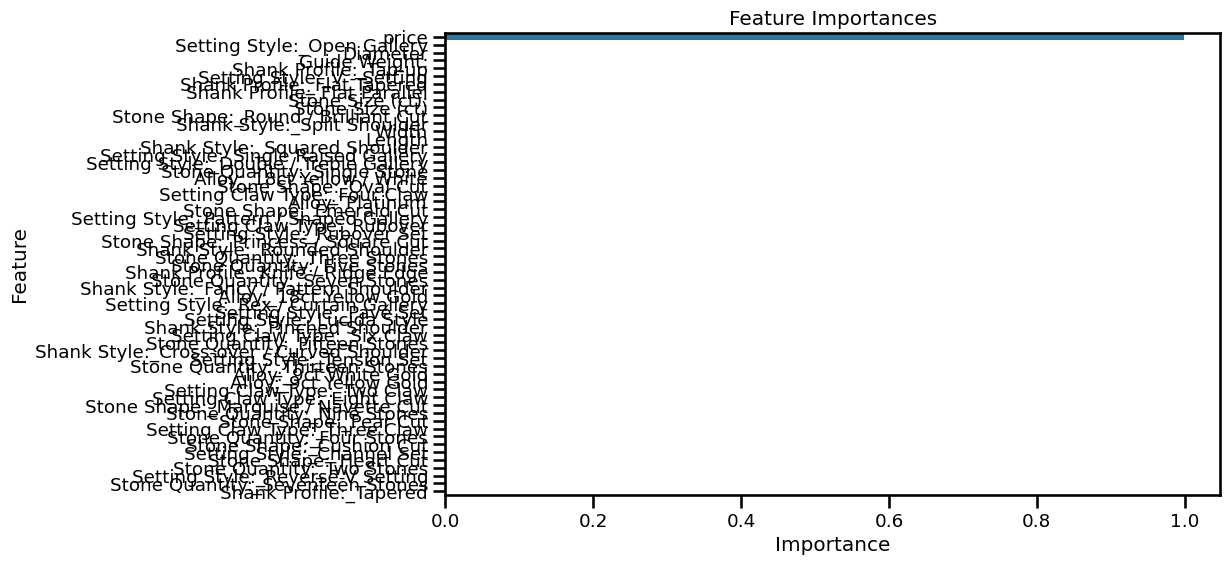

In [24]:
sns.set_context("talk", font_scale=0.8)

# Extract the best model from grid search
best_model = grid_search.best_estimator_.named_steps['model']

# Check if the best model has coefficients (beta values)
if hasattr(best_model, 'coef_'):
    # Get the feature names
    feature_names = X.columns
    # Get the beta coefficients
    betas = best_model.coef_
    
    # Create a DataFrame for better visualization
    beta_df = pd.DataFrame({'Feature': feature_names, 'Beta': betas})
    beta_df = beta_df.sort_values(by='Beta', ascending=False)

    # Display the beta coefficients
    print(beta_df)

    # Plot the beta coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Beta', y='Feature', data=beta_df)
    plt.title('Feature Importances (Beta Coefficients)')
    plt.show()
else:
    print("The best model does not have beta coefficients.")

# For tree-based models like RandomForest, plot feature importances
if hasattr(best_model, 'feature_importances_'):
    # Get the feature importances
    importances = best_model.feature_importances_
    
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the feature importances
    importance_df

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances')
    plt.show()
else:
    print("The best model does not have feature importances.")

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_tr_scaled, y_tr)

# Predict on the validation set
y_val_pred = linear_model.predict(X_val_scaled)

# Calculate the mean squared error and R2 score
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")

Root Mean Squared Error (RMSE): 0.05553118730412504
R2 Score: 0.9715269811136088


/var/folders/40/5vr11pfs7d928qvhzmlcd_cc0000gp/T/ipykernel_51712/4089705778.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, color='red', label='Ideal Fit')


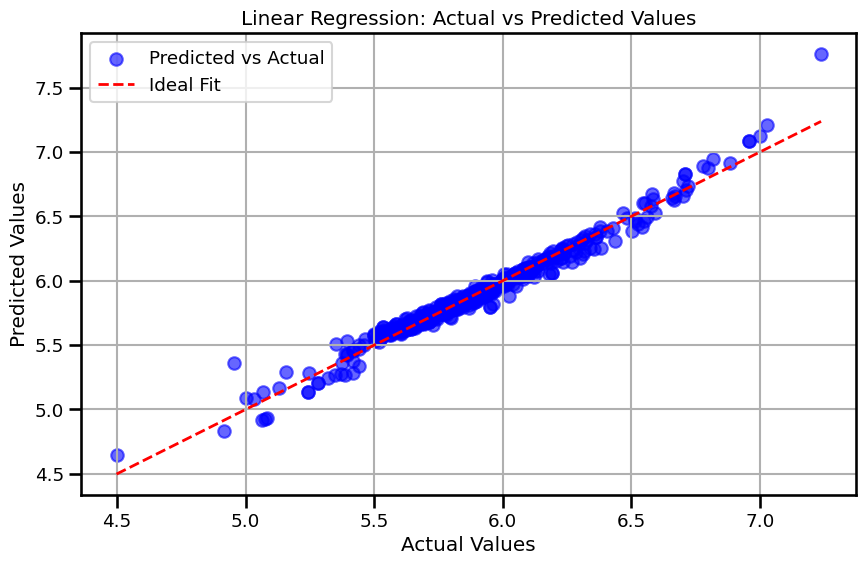

In [26]:
# Plot actual vs predicted values for the linear regression model
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, color='red', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show();

In [27]:
# Extract feature names from X
feature_names = X.columns

# Extract beta coefficients from the linear regression model
betas = linear_model.coef_

# Create a DataFrame for the beta coefficients of the linear regression model
beta_df = pd.DataFrame({
    'Feature': feature_names,
    'Beta': betas
})

# Disable scientific formatting for better readability
pd.options.display.float_format = '{:.6f}'.format

# Display the beta coefficients
beta_df = beta_df.sort_values(by='Beta', ascending=False)
beta_df



,Feature,Beta
2,price,0.218713
4,Length,0.112077
3,Diameter,0.086359
0,Guide Weight:,0.062027
24,Setting Claw Type:_Four Claw,0.050479
26,Setting Claw Type:_Six Claw,0.046677
45,Stone Quantity:_Seven Stones,0.018552
12,Shank Profile:_Flat Parallel,0.018516
25,Setting Claw Type:_Rubover,0.016224
47,Stone Quantity:_Single Stone,0.015639


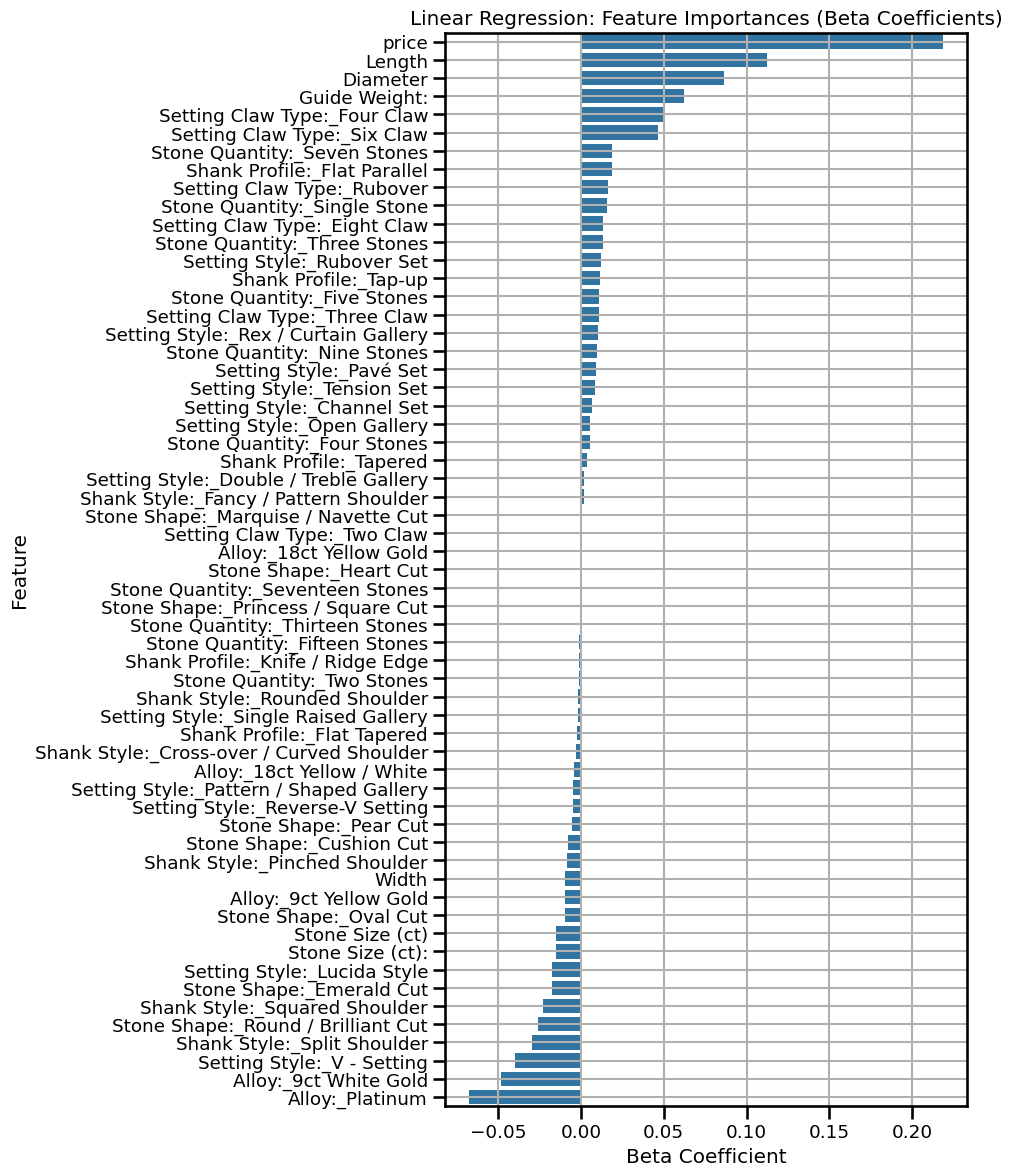

In [28]:
# Adjust font size for better readability
sns.set_context("talk", font_scale=0.8)

# Plot the beta coefficients
plt.figure(figsize=(10, 12))  # Increase figure height for better spacing
sns.barplot(x='Beta', y='Feature', data=beta_df)
plt.title('Linear Regression: Feature Importances (Beta Coefficients)')
plt.xlabel('Beta Coefficient')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

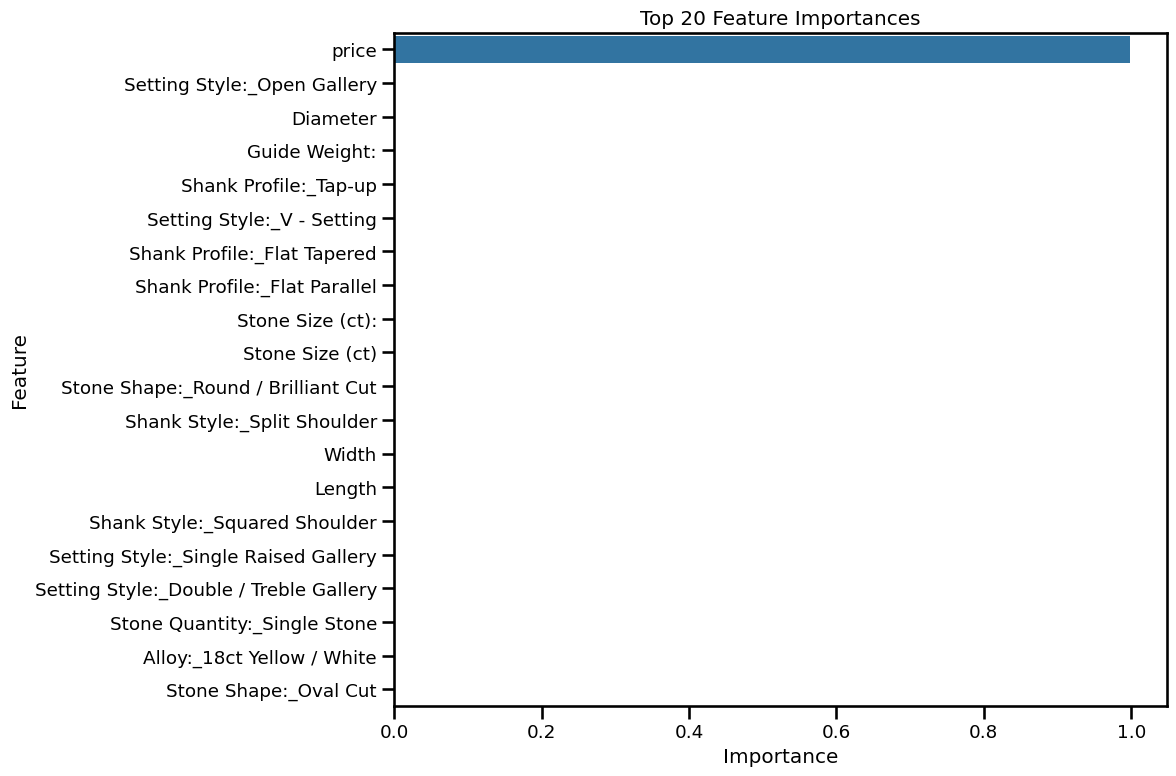

In [29]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False).head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show();

In [30]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions for RandomForestRegressor on the validation set
y_val_pred_rf = best_model.predict(X_val_scaled)

# Calculate RMSE and R² for RandomForestRegressor
rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
r2_rf = r2_score(y_val, y_val_pred_rf)

# Calculate RMSE and R² for LinearRegression (recompute if necessary)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred))  # Recompute RMSE for LinearRegression
r2_lr = r2  # r2 is already defined for LinearRegression

# Differences
rmse_diff = rmse_lr - rmse_rf
r2_diff = r2_lr - r2_rf

print(f"RMSE Difference (LinearRegression - RandomForest): {rmse_diff}")
print(f"R² Difference (LinearRegression - RandomForest): {r2_diff}")

RMSE Difference (LinearRegression - RandomForest): 0.04843687329437798
R² Difference (LinearRegression - RandomForest): -0.028008310604269893


In [31]:
# Assuming `feature_names` contains the names of the features and `betas` contains the coefficients
intercept = linear_model.intercept_  # Intercept of the model
formula = f"Logistic Regression Formula: logit(P) = {intercept:.4f}"

for feature, beta in zip(feature_names, betas):
    formula += f" + ({beta:.4f} * {feature})"

print(formula)

Logistic Regression Formula: logit(P) = 5.9081 + (0.0620 * Guide Weight:) + (-0.0148 * Stone Size (ct):) + (0.2187 * price) + (0.0864 * Diameter) + (0.1121 * Length) + (-0.0097 * Width) + (-0.0148 * Stone Size (ct)) + (-0.0044 * Alloy:_18ct Yellow / White) + (0.0003 * Alloy:_18ct Yellow Gold) + (-0.0480 * Alloy:_9ct White Gold) + (-0.0099 * Alloy:_9ct Yellow Gold) + (-0.0676 * Alloy:_Platinum) + (0.0185 * Shank Profile:_Flat Parallel) + (-0.0027 * Shank Profile:_Flat Tapered) + (-0.0012 * Shank Profile:_Knife / Ridge Edge) + (0.0116 * Shank Profile:_Tap-up) + (0.0039 * Shank Profile:_Tapered) + (-0.0032 * Shank Style:_Cross-over / Curved Shoulder) + (0.0018 * Shank Style:_Fancy / Pattern Shoulder) + (-0.0087 * Shank Style:_Pinched Shoulder) + (-0.0017 * Shank Style:_Rounded Shoulder) + (-0.0293 * Shank Style:_Split Shoulder) + (-0.0229 * Shank Style:_Squared Shoulder) + (0.0134 * Setting Claw Type:_Eight Claw) + (0.0505 * Setting Claw Type:_Four Claw) + (0.0162 * Setting Claw Type:_Rub

In [32]:
# Create a DataFrame for the beta coefficients
beta_df = pd.DataFrame({
    'Feature': feature_names,
    'Beta': betas
})

# Sort the DataFrame by the absolute value of the beta coefficients for better visualization
beta_df = beta_df.reindex(beta_df['Beta'].sort_values(ascending=False).index)

# Display the DataFrame
beta_df

,Feature,Beta
2,price,0.218713
4,Length,0.112077
3,Diameter,0.086359
0,Guide Weight:,0.062027
24,Setting Claw Type:_Four Claw,0.050479
26,Setting Claw Type:_Six Claw,0.046677
45,Stone Quantity:_Seven Stones,0.018552
12,Shank Profile:_Flat Parallel,0.018516
25,Setting Claw Type:_Rubover,0.016224
47,Stone Quantity:_Single Stone,0.015639


In [33]:
# Test the model on the test set
y_test_pred = linear_model.predict(X_test_scaled)
# Calculate RMSE and R² for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
# Calculate the differences
rmse_diff = rmse_lr - rmse_test
r2_diff = r2_lr - r2_test

# Create a DataFrame to display the R2 and RMSE metrics
metrics_df = pd.DataFrame({
    'Metric': ['Validation', 'Test', 'Difference'],
    'R2': [r2, r2_test, r2_diff],
    'RMSE': [rmse, rmse_test, rmse_diff]
})

# Display the DataFrame
metrics_df


,Metric,R2,RMSE
0,Validation,0.971527,0.055531
1,Test,0.960554,0.068406
2,Difference,0.010973,-0.012875
